In [ ]:
!nvidia-smi
%matplotlib inline

Mon Jul  7 11:41:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   31C    P0             50W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

In [2]:
# For Snellius
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

## QA implementations

#### Loading back the classified subsets

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_GoogleNQ_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="BASELINE_classified_GoogleNQ_sample_FS.jsonl",
    split="train"
)

#### Loading an LLM for short and long QA programs

In [ ]:
from openai import OpenAI

client = OpenAI() # Delete when sharing

In [4]:
def ask_short_answer(question, client, model="gemini-2.5-flash", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with concise responses. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
            
    return ["[Error]: Max retries exceeded"]

def ask_long_answer(question, client, model="gemini-2.5-flash", temperature=0.7, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question thoroughly and helpfully. Provide context, explanations, and relevant details "
        "from Wikipedia that would help the user understand the topic better."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return "[Error]: Max retries exceeded"

### Helper functions to run QA in batches

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

def run_batch_longQA_api(batch, client, **kwargs):
    long_answers = []
    for q in batch["question"]:
        try:
            answer = ask_long_answer(q, client=client, **kwargs)
            long_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            long_answers.append("error")
    return {"model_long_answer": long_answers}

def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=10, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

#### Implementation

In [6]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gemini-2.5-flash",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 46/46 [12:19<00:00, 16.08s/it]


In [7]:
long_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gemini-2.5-flash",
    temperature=0.7
)

Running model_long_answer: 100%|██████████| 46/46 [1:36:15<00:00, 125.56s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gemini-2.5-flash",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 55/55 [37:10<00:00, 40.56s/it]   


In [9]:
long_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gemini-2.5-flash",
    temperature=0.7
) 

Running model_long_answer: 100%|██████████| 55/55 [1:46:01<00:00, 115.66s/it]


In [10]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])
for key in long_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, long_results_UND[key])

qa_underspecified.to_json("BASELINE_GoogleNQ_UND_qa_Gemini.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

4162873

In [11]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("BASELINE_GoogleNQ_FS_qa_Gemini.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2360854

In [12]:
fully_specified_set = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_qa_Gemini.jsonl",
    split="train"
)

qa_fully_specified = deepcopy(fully_specified_set)

for key in long_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, long_results_FS[key])

qa_fully_specified.to_json("BASELINE_GoogleNQ_FS_qa_Gemini.jsonl", orient="records", lines=True)

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

5245316

In [14]:
df = pd.read_json("BASELINE_GoogleNQ_UND_qa_Gemini.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_UND_qa_Gemini.csv')

df = pd.read_json("BASELINE_GoogleNQ_FS_qa_Gemini.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_FS_qa_Gemini.csv')

## Evaluations

In [15]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_qa_Gemini.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_qa_Gemini.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Squad EM + F1

In [16]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="BASELINE_GoogleNQ_FS_qa_Gemini.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 29.70
F1 Score: 47.38


In [17]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="BASELINE_GoogleNQ_UND_qa_Gemini.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 20.09
F1 Score: 38.54


In [18]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="short_answers"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [19]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("BASELINE_Google_NQ_UND_qa_Gemini_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

4171420

In [20]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("BASELINE_Google_NQ_FS_qa_Gemini_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

5255242

In [21]:
df = pd.read_json("BASELINE_Google_NQ_UND_qa_Gemini_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_Google_NQ_UND_qa_Gemini_with_squad_scores.csv')

df = pd.read_json("BASELINE_Google_NQ_FS_qa_Gemini_with_squad_scores.jsonl", lines=True)
df.to_csv('BASELINE_Google_NQ_FS_qa_Gemini_with_squad_scores.csv')

In [22]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 20.31
UND F1 Score (avg): 38.76
FS Exact Match (avg): 29.70
FS F1 Score (avg): 47.38
F1: t=3.387, p=0.0007
EM: t=3.455, p=0.0006


#### Visualization

In [23]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("Gemini 2.5 Flash F1 Score Distribution by Subset_BASELINE - GoogleNQ")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("GoogleNQ_f1_boxplot_Gemini_BASELINE.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("Gemini 2.5 Flash Exact Match Rate by Subset_BASELINE (± CI) - GoogleNQ")
plt.tight_layout()
plt.savefig("GoogleNQ_em_barplot_Gemini_BASELINE.png", dpi=300)
plt.close()

/scratch-local/yhuang.14598371/ipykernel_2878201/3092604752.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.14598371/ipykernel_2878201/3092604752.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.14598371/ipykernel_2878201/3092604752.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


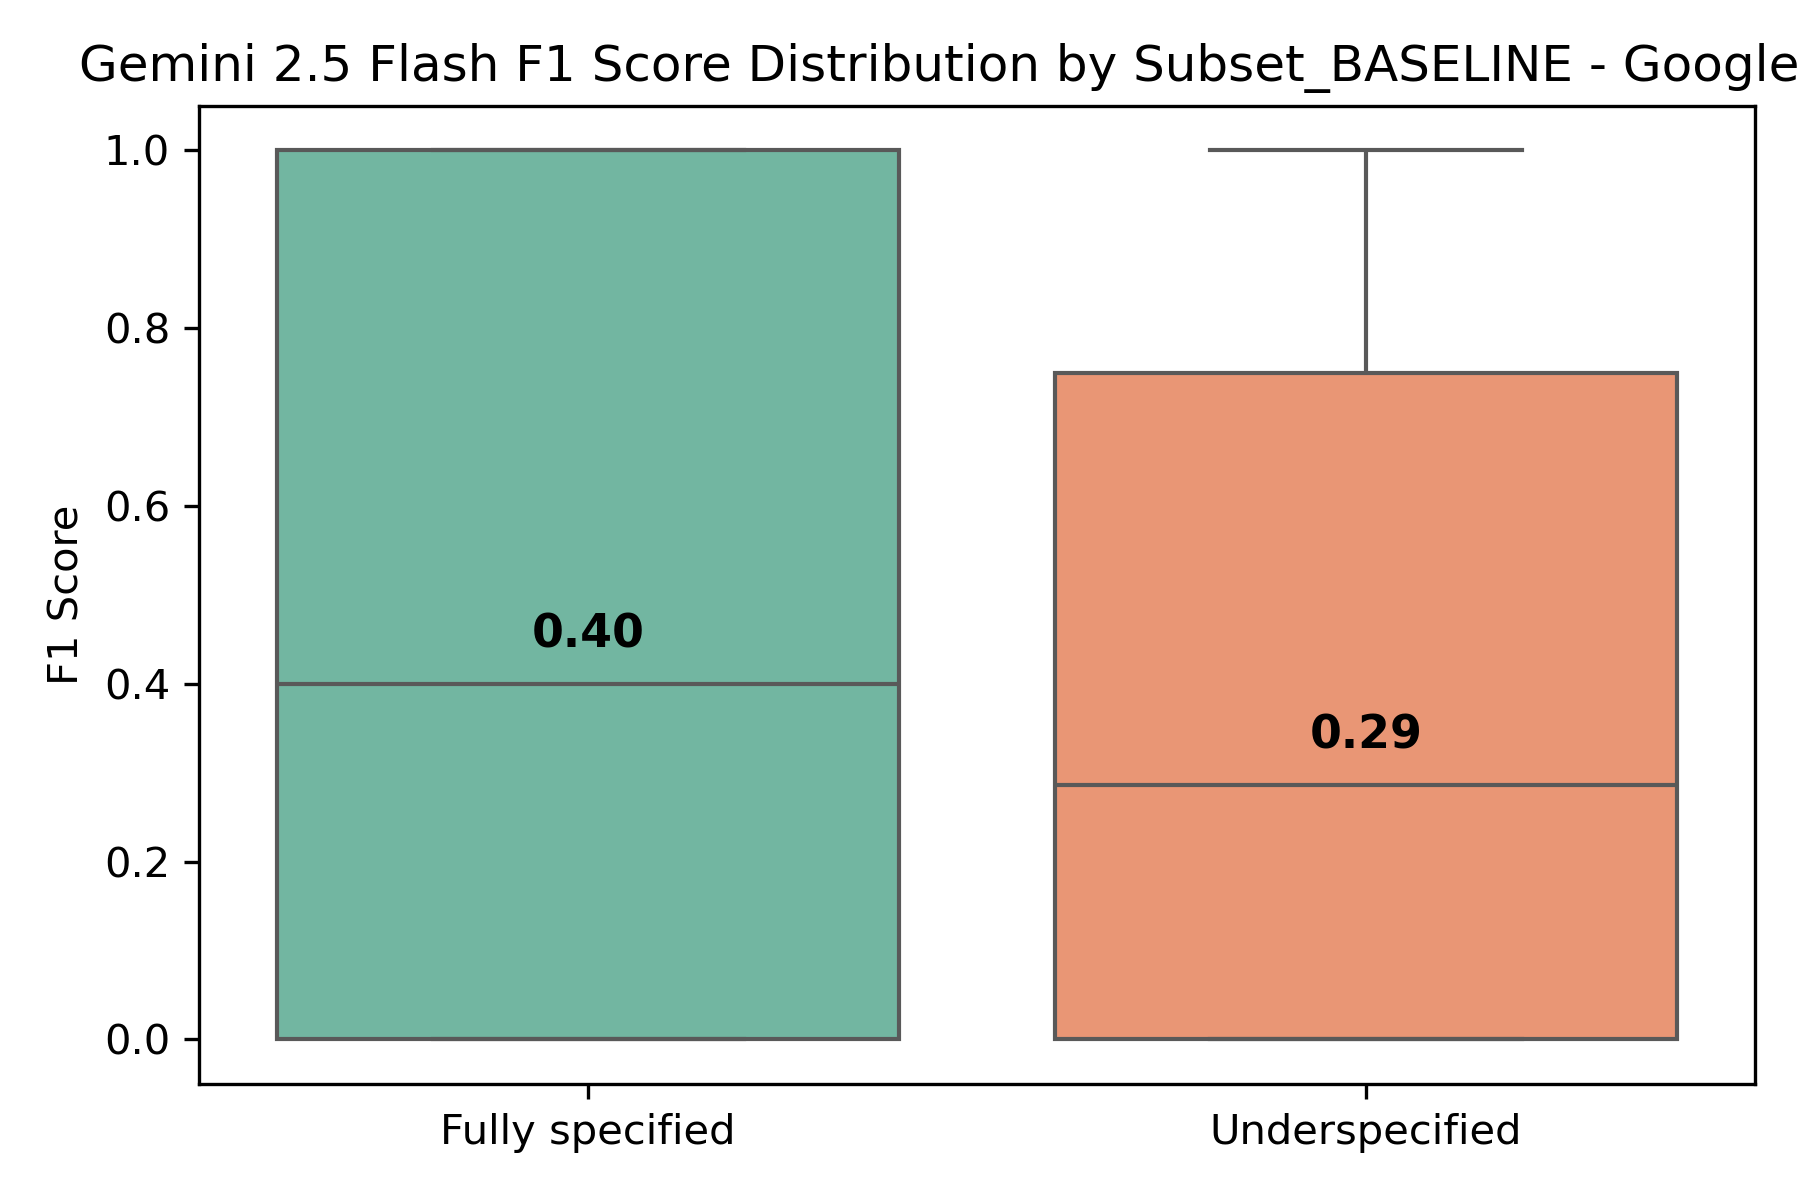

In [24]:
from IPython.display import Image
Image("GoogleNQ_f1_boxplot_Gemini_BASELINE.png")

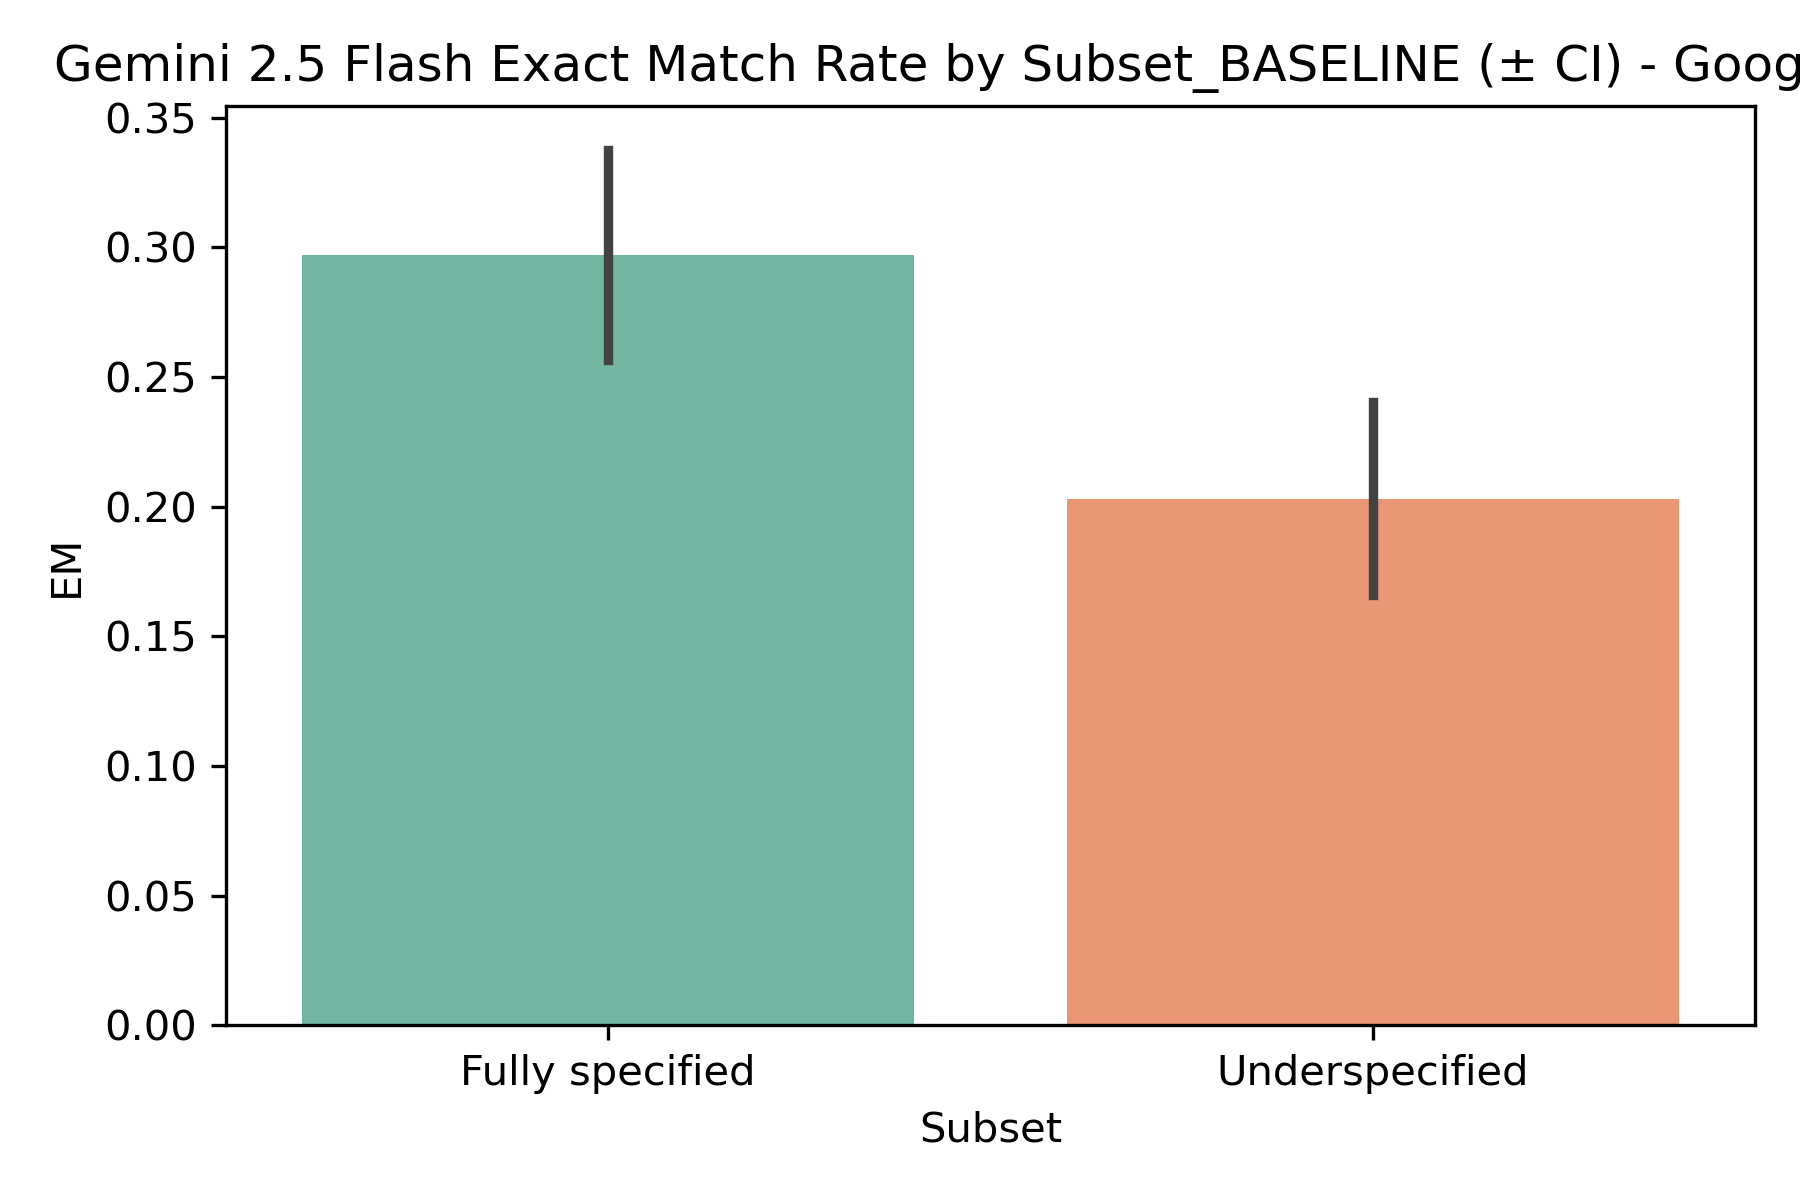

In [25]:
Image("GoogleNQ_em_barplot_Gemini_BASELINE.png")

#### BLEU, ROUGE, METEOR, BERTScore

In [3]:
UND = load_dataset(
    "json",
    data_files="BASELINE_Google_NQ_UND_qa_Gemini_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS = load_dataset(
    "json",
    data_files="BASELINE_Google_NQ_FS_qa_Gemini_with_squad_scores.jsonl",
    split="train"
)

In [4]:
def evaluate_long_answer_all_metrics(
    dataset: Dataset,
    pred_col: str,
    ref_col: str,
    metrics: list = ["bleu", "meteor", "rouge", "bertscore"]
) -> dict:
    """
    对 dataset 中每条样本逐一计算多个文本生成评估指标。
    支持 BLEU, METEOR, ROUGE-L, BERTScore。

    Args:
        dataset: HuggingFace Dataset。
        pred_col: 模型预测列名（str）。
        ref_col: 参考答案列名（str）。
        metrics: 要计算的指标列表，支持 "bleu", "meteor", "rouge", "bertscore"。

    Returns:
        Dict[str, List[float]]: 每个指标对应一个分数列表。
    """
    metric_objects = {m: evaluate.load(m) for m in metrics}
    all_scores = {m: [] for m in metrics}

    for item in tqdm(dataset, desc="Evaluating metrics"):
        pred = item[pred_col]
        ref = item[ref_col]

        if not pred or not ref:
            for m in metrics:
                all_scores[m].append(0.0)
            continue

        for m in metrics:
            try:
                if m == "rouge":
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result["rougeL"])
                elif m == "bertscore":
                    result = metric_objects[m].compute(predictions=[pred], references=[ref], lang="en")
                    all_scores[m].append(result["f1"][0])  # 取 BERTScore F1 分数
                else:
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result[m])
            except Exception as e:
                print(f"Error scoring sample with {m}: {e}")
                all_scores[m].append(0.0)

    return all_scores

def add_scores_to_dataset(dataset, scores_dict):
    """
    将多个指标打分列表合并为 dataset 的新列。

    Args:
        dataset (Dataset): 原始 HuggingFace Dataset。
        scores_dict (dict): 如 {"bleu": [...], "meteor": [...]}，每个值都是 len=N 的分数列表。

    Returns:
        Dataset: 增加了评估分数的新数据集。
    """

    # 确保每个指标的分数长度与数据集行数一致
    for k, v in scores_dict.items():
        assert len(v) == len(dataset), f"Length mismatch for {k}: {len(v)} != {len(dataset)}"

    # 加入每个指标为新列
    new_dataset = dataset
    for k, v in scores_dict.items():
        new_dataset = new_dataset.add_column(k, v)

    return new_dataset
def t_test_metrics(scores_1: dict, scores_2: dict, label_1="Group 1", label_2="Group 2"):
    """
    对两个子集的多个指标进行 t-test，并打印结果。

    Args:
        scores_1 (dict): 子集 1 的评估分数，形式为 {"metric": [scores]}。
        scores_2 (dict): 子集 2 的评估分数，形式相同。
    """
    common_metrics = set(scores_1.keys()) & set(scores_2.keys())

    print(f"\nT-test results between {label_1} and {label_2}:\n")
    for metric in sorted(common_metrics):
        x = scores_1[metric]
        y = scores_2[metric]

        t_stat, p_val = ttest_ind(x, y, equal_var=False)
        print(f"{metric.upper():<10} | t = {t_stat:6.3f} | p = {p_val:.4f} | "
              f"{'significant' if p_val < 0.05 else 'not significant'}")

def plot_metric_distributions(scores_1, scores_2, label_1="Group 1", label_2="Group 2", filename="BASELINE_Google_NQ_metric_plot.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    # 构建 DataFrame
    rows = []
    for metric in scores_1:
        if metric in scores_2:
            for v in scores_1[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_1})
            for v in scores_2[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_2})
    df = pd.DataFrame(rows)

    # 绘图设置
    sns.set(style="whitegrid", font_scale=1.1)
    g = sns.catplot(
        data=df, kind="box", x="metric", y="score", hue="group",
        height=5, aspect=1.6, palette="Set2", showfliers=True  # Keep outliers，remove swarm
    )

    g.set_axis_labels("Metric", "Score")
    g.set_titles("Metric Score Distributions")
    g.despine(left=True)
    plt.title("Gemini 2.5 Flash Long Answer Evaluation Score Distributions by Group_BASELINE")
    plt.tight_layout()
    plt.savefig(filename,dpi=300)
    plt.close()

    return Image(filename)

In [5]:
scores_UND = evaluate_long_answer_all_metrics(
    dataset=UND,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

scores_FS = evaluate_long_answer_all_metrics(
    dataset=FS,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yhuang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating metrics:   0%|          | 0/458 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating metrics: 100%|██████████| 458/458 [38:02<00:00,  4.98s/it]
[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab 

In [6]:
# 合并
UND_with_most_metrics = add_scores_to_dataset(UND, scores_UND)
FS_with_most_metrics = add_scores_to_dataset(FS, scores_FS)

# 保存为新 jsonl（可选）
UND_with_most_metrics.to_json("BASELINE_GoogleNQ_UND_Gemini_with_most_metrics.jsonl")
FS_with_most_metrics.to_json("BASELINE_GoogleNQ_FS_Gemini_with_most_metrics.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

5301006

In [7]:
t_test_metrics(scores_FS, scores_UND, label_1="UND", label_2="FS")


T-test results between UND and FS:

BERTSCORE  | t =  1.563 | p = 0.1185 | not significant
BLEU       | t =  2.298 | p = 0.0217 | significant
METEOR     | t =  1.941 | p = 0.0526 | not significant
ROUGE      | t =  2.884 | p = 0.0040 | significant


/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/scratch-local/yhuang.14599722/ipykernel_3140305/4199449253.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


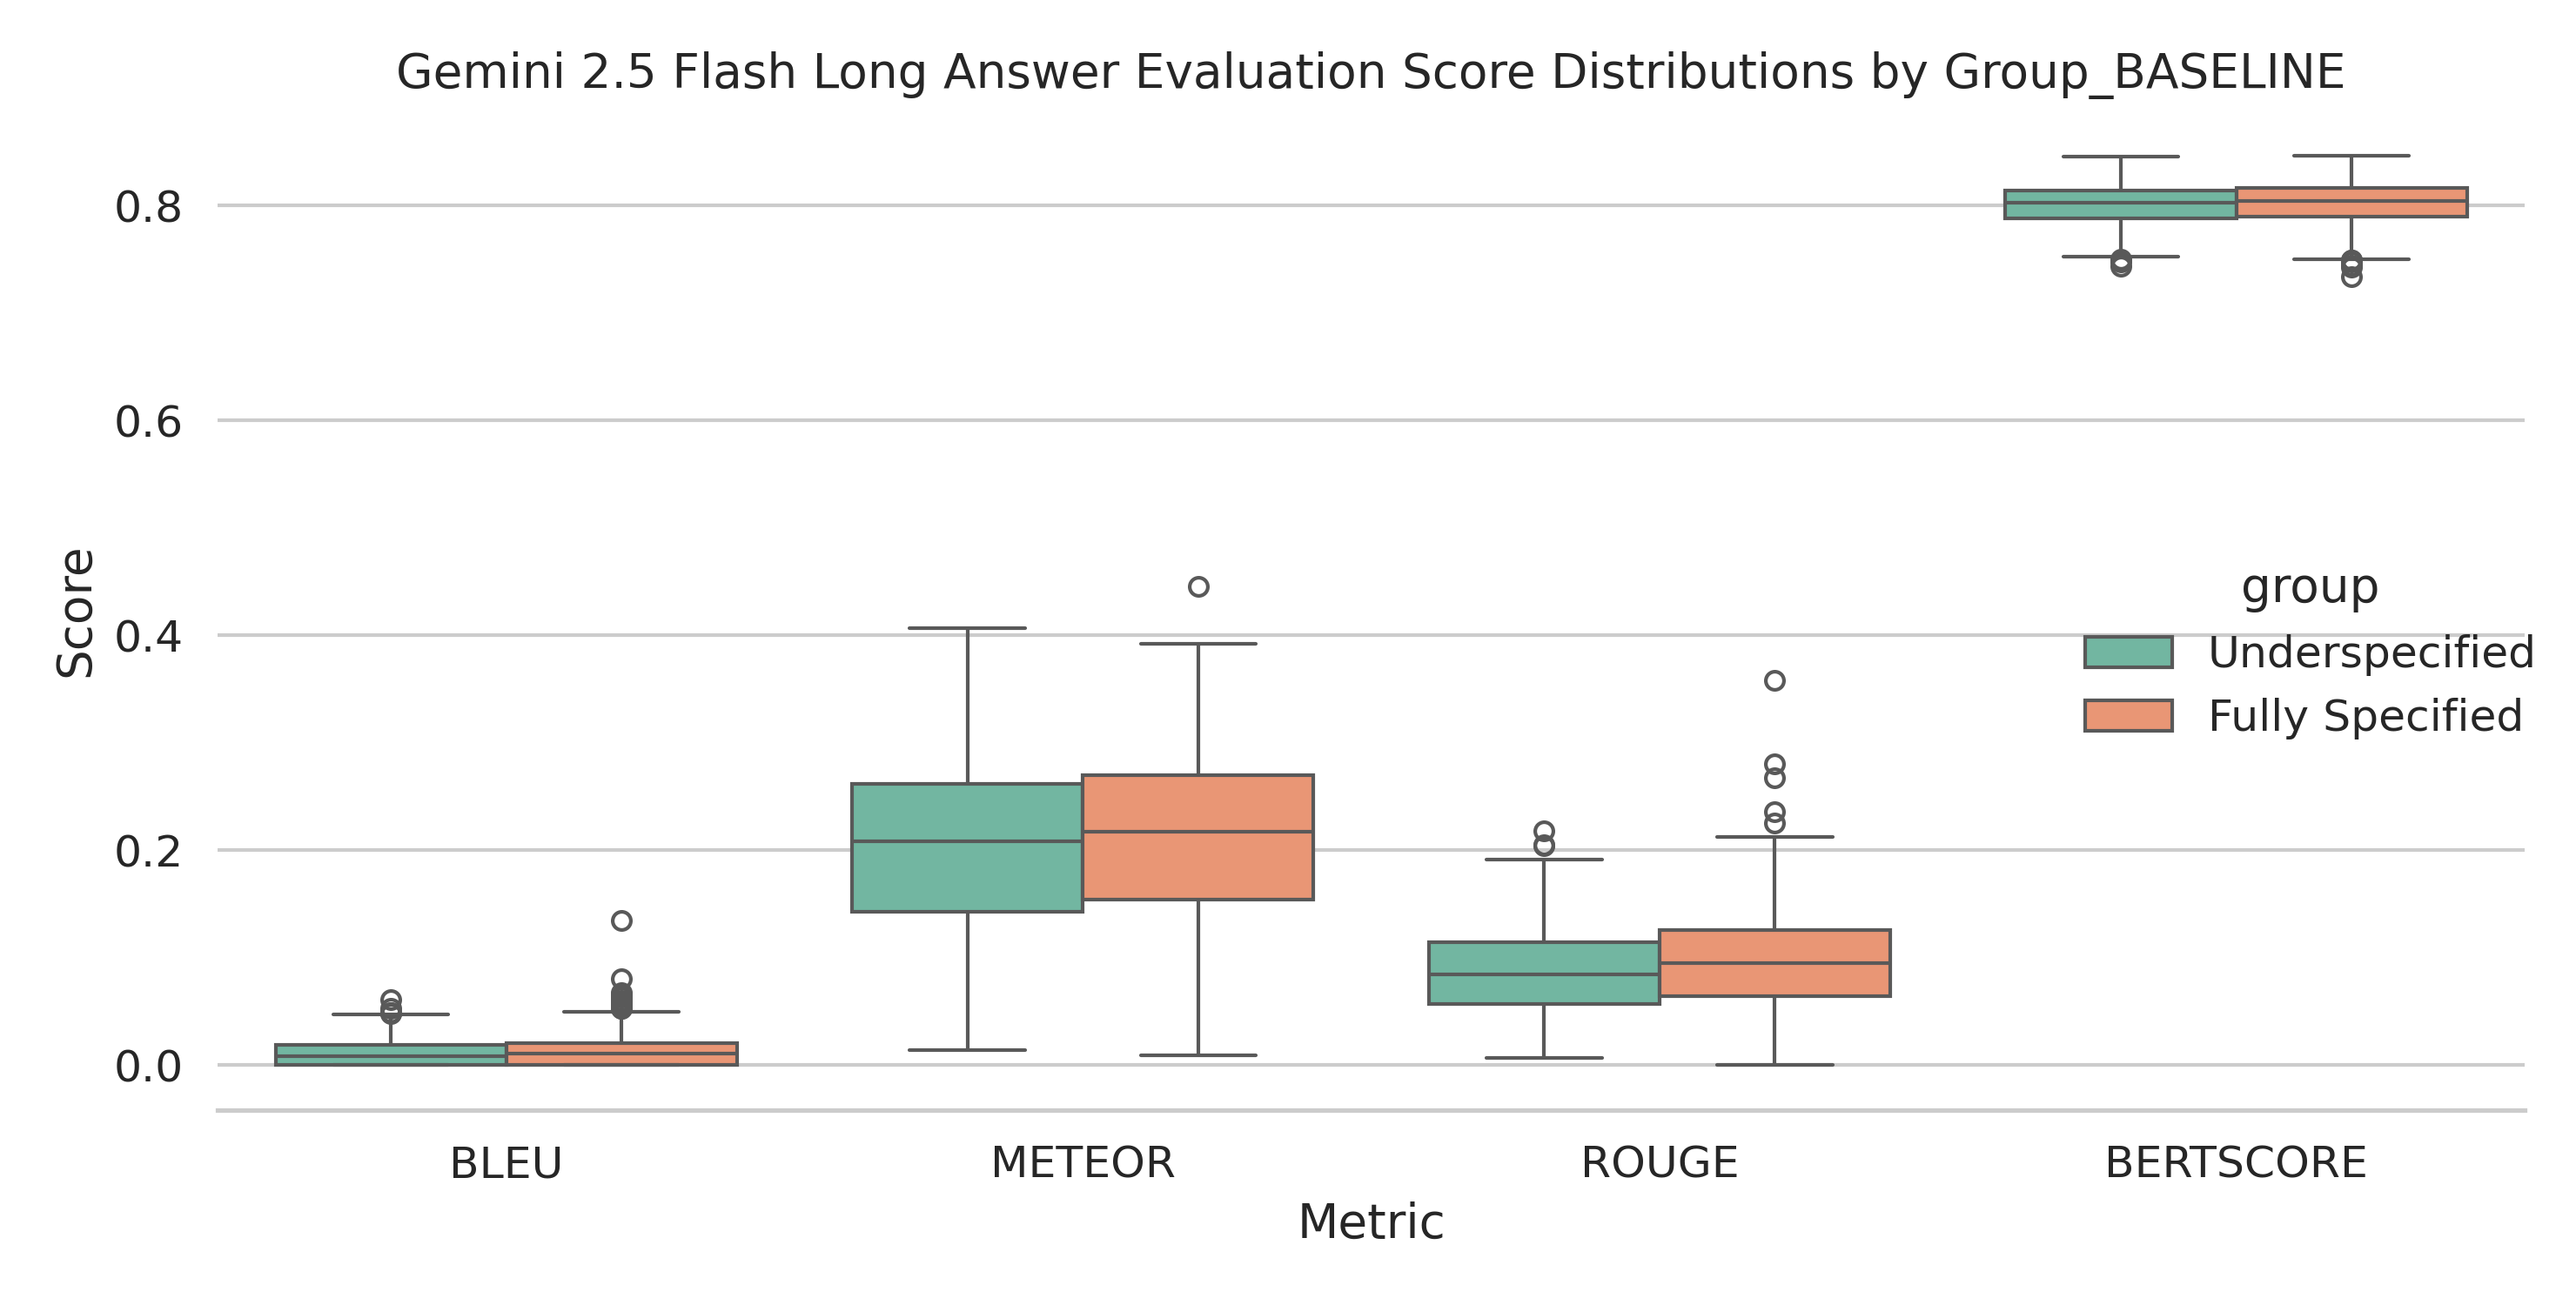

In [8]:
plot_metric_distributions(scores_UND, scores_FS, label_1="Underspecified", label_2="Fully Specified")

In [9]:
df = pd.read_json("BASELINE_GoogleNQ_UND_Gemini_with_most_metrics.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_UND_Gemini_with_most_metrics.csv')
df = pd.read_json("BASELINE_GoogleNQ_FS_Gemini_with_most_metrics.jsonl", lines=True)
df.to_csv('BASELINE_GoogleNQ_FS_Gemini_with_most_metrics.csv')

In [2]:
UND_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_Gemini_with_most_metrics.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_Gemini_with_most_metrics.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [3]:
print(f'Gemini 2.5 Flash Google NQ UND qa average BLEU: {np.mean(UND_full["bleu"])}')
print(f'Gemini 2.5 Flash Google NQ FS qa average BLEU: {np.mean(FS_full["bleu"])}')
print(f'Gemini 2.5 Flash Google NQ UND qa average METEOR: {np.mean(UND_full["meteor"])}')
print(f'Gemini 2.5 Flash Google NQ FS qa average METEOR: {np.mean(FS_full["meteor"])}')
print(f'Gemini 2.5 Flash Google NQ UND qa average ROUGE: {np.mean(UND_full["rouge"])}')
print(f'Gemini 2.5 Flash Google NQ FS qa average ROUGE: {np.mean(FS_full["rouge"])}')
print(f'Gemini 2.5 Flash Google NQ UND qa average BERTSCORE: {np.mean(UND_full["bertscore"])}')
print(f'Gemini 2.5 Flash Google NQ FS qa average BERTSCORE: {np.mean(FS_full["bertscore"])}')

Gemini 2.5 Flash Google NQ UND qa average BLEU: 0.011249273238209607
Gemini 2.5 Flash Google NQ FS qa average BLEU: 0.013227550667527675
Gemini 2.5 Flash Google NQ UND qa average METEOR: 0.20079178584170307
Gemini 2.5 Flash Google NQ FS qa average METEOR: 0.21096168029446494
Gemini 2.5 Flash Google NQ UND qa average ROUGE: 0.08866591901004367
Gemini 2.5 Flash Google NQ FS qa average ROUGE: 0.0964706858699262
Gemini 2.5 Flash Google NQ UND qa average BERTSCORE: 0.7998354765550219
Gemini 2.5 Flash Google NQ FS qa average BERTSCORE: 0.8017738481309963


In [4]:
print(f'gpt_4o Google NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o Google NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o Google NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o Google NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o Google NQ UND qa EM SD: 0.4022744303349993
gpt_4o Google NQ FS qa EM SD: 0.45695784675787465
gpt_4o Google NQ UND qa F1 SD: 0.39022663997593426
gpt_4o Google NQ FS qa F1 SD: 0.4129333849331884


In [7]:
print(f'gpt_4o Google NQ UND qa BLEU SD: {np.std(UND_full["bleu"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa BLEU SD: {np.std(FS_full["bleu"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa METEOR SD: {np.std(UND_full["meteor"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa METEOR SD: {np.std(FS_full["meteor"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa ROUGE SD: {np.std(UND_full["rouge"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa ROUGE SD: {np.std(FS_full["rouge"])* 100:.1f}')
print(f'gpt_4o Google NQ UND qa BERTSCORE SD: {np.std(UND_full["bertscore"])* 100:.1f}')
print(f'gpt_4o Google NQ FS qa BERTSCORE SD: {np.std(FS_full["bertscore"])* 100:.1f}')

gpt_4o Google NQ UND qa BLEU SD: 1.2
gpt_4o Google NQ FS qa BLEU SD: 1.5
gpt_4o Google NQ UND qa METEOR SD: 8.1
gpt_4o Google NQ FS qa METEOR SD: 8.4
gpt_4o Google NQ UND qa ROUGE SD: 4.1
gpt_4o Google NQ FS qa ROUGE SD: 4.5
gpt_4o Google NQ UND qa BERTSCORE SD: 1.9
gpt_4o Google NQ FS qa BERTSCORE SD: 2.0


In [8]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [9]:
welch_df(300, np.std(UND_full["em"]), 700, np.std(FS_full["em"]))

635.0904779874571

In [10]:
welch_df(300, np.std(UND_full["f1"]), 700, np.std(FS_full["f1"]))

594.1066753817382

### Ragas evaluation

In [2]:
from ragas.llms import LangchainLLMWrapper
from langchain_deepseek import ChatDeepSeek
from ragas.dataset_schema import SingleTurnSample
from ragas.metrics import AnswerAccuracy
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
evaluator_llm = LangchainLLMWrapper(ChatDeepSeek(model="deepseek-chat", verbose=True, temperature=0))

UND_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_UND_Gemini_with_most_metrics.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="BASELINE_GoogleNQ_FS_Gemini_with_most_metrics.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
sample = SingleTurnSample(
    user_input="When was Einstein born?",
    response="Albert Einstein was born in 1879.",
    reference="Albert Einstein was born in 1879."
)

scorer = AnswerAccuracy(llm=evaluator_llm) # evaluator_llm wrapped with ragas LLM Wrapper
score = await scorer.single_turn_ascore(sample)
print(score)

1.0


In [36]:
async def test_single_sample(row, evaluator=evaluator_llm):
    """测试单个样本的评分"""
    scorer = AnswerAccuracy(llm=evaluator)
    
    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
    reference_answers = row['short_answers'] if isinstance(row['short_answers'], list) else [row['short_answers']]
    
    print(f"模型答案: {model_answers}")
    print(f"参考答案: {reference_answers}")
    
    max_score = 0.0
    best_combination = None
    
    for i, model_ans in enumerate(model_answers):
        for j, ref_ans in enumerate(reference_answers):
            sample = SingleTurnSample(
                user_input=row['question'],
                response=model_ans,
                reference=ref_ans
            )
            score = await scorer.single_turn_ascore(sample)
            print(f"组合 {i+1}-{j+1}: 分数 = {score}")
            
            if score > max_score:
                max_score = score
                best_combination = (model_ans, ref_ans)
    
    print(f"最高分数: {max_score}")
    print(f"最佳组合: {best_combination}")
    return max_score
# 测试使用
test_score = await test_single_sample(FS_full[0])

模型答案: ['1896']
参考答案: ['1924']
组合 1-1: 分数 = 0.0
最高分数: 0.0
最佳组合: None


In [39]:
async def answer_accuracy(input_dataset, long_answer=False, evaluator=evaluator_llm):
    # 在函数开始时创建一次 scorer
    scorer = AnswerAccuracy(llm=evaluator)
    
    if long_answer:
        score_list_long = []
        score_list_short = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short and long answer accuracy")):
            try:
                # 长答案评分
                if 'model_long_answer' in row and 'long_answer' in row:
                    sample_long = SingleTurnSample(
                        user_input=row['question'],
                        response=row['model_long_answer'],
                        reference=row['long_answer']
                    )
                    score_long = await scorer.single_turn_ascore(sample_long)
                    score_list_long.append(score_long)
                else:
                    score_list_long.append(0.0)

                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'short_answers' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['short_answers'] if isinstance(row['short_answers'], list) else [row['short_answers']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample_short = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample_short)
                            max_score = max(max_score, score)
                    
                    score_list_short.append(max_score)
                else:
                    score_list_short.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list_long.append(0.0)
                score_list_short.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_long", score_list_long)
        ragas_scored_dataset = ragas_scored_dataset.add_column("ragas_AA_short", score_list_short)

        return ragas_scored_dataset
    else:
        score_list = []
        
        for i, row in enumerate(tqdm(input_dataset, desc="Calculating short answer accuracy")):
            try:
                # 短答案评分 - 处理列表情况
                if 'model_short_answer' in row and 'short_answers' in row:
                    model_answers = row['model_short_answer'] if isinstance(row['model_short_answer'], list) else [row['model_short_answer']]
                    reference_answers = row['short_answers'] if isinstance(row['short_answers'], list) else [row['short_answers']]
                    
                    # 计算所有组合的分数，取最高分
                    max_score = 0.0
                    for model_ans in model_answers:
                        for ref_ans in reference_answers:
                            sample = SingleTurnSample(
                                user_input=row['question'],
                                response=model_ans,
                                reference=ref_ans
                            )
                            score = await scorer.single_turn_ascore(sample)
                            max_score = max(max_score, score)
                    
                    score_list.append(max_score)
                else:
                    score_list.append(0.0)
                
            except Exception as e:
                print(f"处理第 {i+1} 个样本时出错: {e}")
                score_list.append(0.0)

        ragas_scored_dataset = input_dataset.add_column("ragas_AA_short", score_list)

        return ragas_scored_dataset

In [40]:
UND_ragas = await answer_accuracy(UND_full)
UND_ragas

Calculating short answer accuracy: 100%|██████████| 458/458 [1:31:19<00:00, 11.96s/it]  


Dataset({
    features: ['question', 'short_answers', 'long_answer', 'qwen3_thinking', 'qwen3_model_response', 'qwen3_model_pred', 'model_short_answer', 'model_long_answer', 'em', 'f1', 'bleu', 'meteor', 'rouge', 'bertscore', 'ragas_AA_short'],
    num_rows: 458
})

In [41]:
UND_ragas.to_csv("GoogleNQ_UND_Gemini_Ragas.csv")

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

4082412

In [43]:
FS_ragas = await answer_accuracy(FS_full)
FS_ragas.to_csv("GoogleNQ_FS_Gemini_Ragas.csv")

Calculating short answer accuracy: 100%|██████████| 542/542 [1:38:20<00:00, 10.89s/it]  


Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

5155224

In [51]:
UND_ragas_AA = list(UND_ragas["ragas_AA_short"])
FS_ragas_AA = list(FS_ragas["ragas_AA_short"])

In [ ]:
UND_mean_AA = np.mean(UND_ragas_AA)
print(f"UND AA (avg): {UND_mean_AA * 100:.2f}")


FS_mean_AA = np.mean(FS_ragas_AA)
print(f"FS AA (avg): {FS_mean_AA * 100:.2f}")

AA_tstat, AA_pval = ttest_ind(FS_ragas_AA, UND_ragas_AA, equal_var=False)
print(f"AA: t={AA_tstat:.3f}, p={AA_pval:.4f}")


UND AA (avg): 54.86
FS AA (avg): 65.27
AA: t=3.753, p=0.0002
